
# **Install Libraries and Setup Kaggle Dataset**

**Description:**
 we will import everything needed for the project, including:
* General libraries
* Image and data processing
* Tensorflow + Keras
* Kaggle + Files handling
* Visualization (matplotlib)

We will set up Kaggle so that we can download the dataset directly from Kaggle and extract it.


In [2]:
# Install necessary libraries
!pip install -q kaggle
!pip install tensorflow

# System and file handling
import os
import shutil
import json

# Data processing
import numpy as np
import pandas as pd

# Image handling
import matplotlib.pyplot as plt
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten,
                                     Dropout, GlobalAveragePooling2D, BatchNormalization)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Google Colab specific tools
from google.colab import files


In [3]:
from tensorflow.keras import mixed_precision
# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU detected and ready: {device_name}")
else:
    print("No GPU detected. Training will be slow. Enable GPU from Runtime → Change runtime type.")

# Enable Mixed Precision
mixed_precision.set_global_policy("mixed_float16")
print("Mixed Precision Enabled → Models will train faster and use less memory.")

# Check TensorFlow version and GPU info
print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


No GPU detected. Training will be slow. Enable GPU from Runtime → Change runtime type.
Mixed Precision Enabled → Models will train faster and use less memory.
TensorFlow version: 2.18.0
Available GPUs: []


#  **Setup Kaggle Dataset**

**Description:**
* Upload kaggle.json
* Setup permissions
* Download dataset using Kaggle API
* Extract dataset to folder aircraft_data

In [8]:
# Upload kaggle.json (API)
uploaded = files.upload()

# Setup Kaggle config folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Move json and set permissions
for filename in uploaded.keys():
    os.rename(filename, "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

print(" Kaggle API configured.")

# Download the aircraft dataset
!kaggle datasets download -d seryouxblaster764/fgvc-aircraft

# Extract downloaded zip
!unzip -q fgvc-aircraft.zip -d aircraft_data

print("Dataset downloaded and extracted.")


Saving kaggle.json to kaggle.json
 Kaggle API configured.
Dataset URL: https://www.kaggle.com/datasets/seryouxblaster764/fgvc-aircraft
License(s): other
Dataset downloaded and extracted.


# **Define Dataset Paths**

**Description:**
 I have adjusted the paths in this section to make it easier to access files while working on training and code.

In [9]:
# Define base path after extraction
base_path = "/content/aircraft_data/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"
# Define important paths
images_path = os.path.join(base_path, "images")
trainval_txt = os.path.join(base_path, "images_variant_trainval.txt")
test_txt = os.path.join(base_path, "images_variant_test.txt")
classified_path = os.path.join(base_path, "classified_images")
# Create classified path if doesn't exist
os.makedirs(classified_path, exist_ok=True)
print("All Paths defined:")
print("Images Path:", images_path)
print("Train/Val TXT Path:", trainval_txt)
print("Test TXT Path:", test_txt)
print("Classified Path:", classified_path)

All Paths defined:
Images Path: /content/aircraft_data/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images
Train/Val TXT Path: /content/aircraft_data/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_variant_trainval.txt
Test TXT Path: /content/aircraft_data/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_variant_test.txt
Classified Path: /content/aircraft_data/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/classified_images


# **Organize Dataset Images**

**Description:**

* Move all images from the images folder to `classified_images`, organizing them into the correct class folders (aircraft type).
*  Remove empty folders to clean up the dataset.
*  Count the number of **classes (folders)** and **images**, ensuring the dataset structure is valid.
*  Print a **warning** if any class folder has no images.
*  Display the total number of classes and images.



**This makes dataset ready for training and clean.**

In [10]:
# Organize images into class folders
def organize_images(txt_file):
    with open(txt_file, 'r') as file:
        for line in file:
            image_id, variant = line.strip().split(" ", 1)
            img_filename = f"{image_id}.jpg"
            variant_folder = os.path.join(classified_path, variant)
            os.makedirs(variant_folder, exist_ok=True)

            src = os.path.join(images_path, img_filename)
            dst = os.path.join(variant_folder, img_filename)

            if os.path.exists(src):
                shutil.move(src, dst)

# Process trainval and test images
organize_images(trainval_txt)
organize_images(test_txt)
print(" Images organized into class folders.")

# Clean inner subfolders and move images WITHOUT renaming
for class_folder in os.listdir(classified_path):
    class_path = os.path.join(classified_path, class_folder)

    if os.path.isdir(class_path):
        for subfolder in os.listdir(class_path):
            subfolder_path = os.path.join(class_path, subfolder)

            if os.path.isdir(subfolder_path):
                for img in os.listdir(subfolder_path):
                    src_img_path = os.path.join(subfolder_path, img)
                    dst_img_path = os.path.join(class_path, img)  # Keep original name
                    shutil.move(src_img_path, dst_img_path)

                # Remove empty subfolder after moving images
                os.rmdir(subfolder_path)

print(" Inner folders cleaned and images kept with original names.")

# Remove empty folders
for root, dirs, files in os.walk(classified_path, topdown=False):
    if not os.listdir(root):
        os.rmdir(root)

print(" Empty folders removed. Dataset is clean.")

# Count total classes and images
total_classes = sum(1 for folder in os.listdir(classified_path) if os.path.isdir(os.path.join(classified_path, folder)))
total_images = sum(len([f for f in os.listdir(os.path.join(classified_path, folder)) if f.endswith(".jpg")]) for folder in os.listdir(classified_path) if os.path.isdir(os.path.join(classified_path, folder)))

print("---------------------------------")
print(f" Total classes: {total_classes}")
print(f" Total images: {total_images}")
print("---------------------------------")


 Images organized into class folders.
 Inner folders cleaned and images kept with original names.
 Empty folders removed. Dataset is clean.
---------------------------------
 Total classes: 100
 Total images: 10000
---------------------------------


# **Prepare Data Generators and Augmentation**

**Description:**

* Prepared the data for training using ImageDataGenerator.
* Implemented optimizations such as rotation, zoom, pan, horizontal flip, brightness adjustment, and color channel changes to improve model accuracy.
* Split the data so that 80% was for training and 20% for validation to ensure model balance.
* Used a batch size of 32 to achieve a good balance between accuracy and training speed.
* Created data generators (train_generator and val_generator) to facilitate automatic image loading from classification folders.
* Organized the data and prepared it to improve model performance during training.


In [ ]:


# Set batch size
BATCH_SIZE = 64

# Create ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize images
    validation_split=0.2,        # Reserve 20% for validation
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,       # Shift images horizontally
    height_shift_range=0.1,      # Shift images vertically
    shear_range=0.1,             # Apply shearing transformations
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Flip images horizontally
    brightness_range=[0.8, 1.2]  # Random brightness
)

# Create ImageDataGenerator for validation )
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    classified_path,             # Path to classified images
    target_size=(224, 224),      # Resize images to 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical',    # For multi-class classification
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    classified_path,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Print info
print(" Data generators are ready.")
print("Total Training Samples:", train_generator.samples)
print("Total Validation Samples:", val_generator.samples)
print("Total Classes:", train_generator.num_classes)


Found 8000 images belonging to 100 classes.
Found 2000 images belonging to 100 classes.
 Data generators are ready.
Total Training Samples: 8000
Total Validation Samples: 2000
Total Classes: 100


# **CNN Model**

**Build the CNN Model**

**Description:**
* I created a CNN model for aircraft classification.
* I used convolutional layers (Conv2D) to extract features.
* I applied MaxPooling to reduce data size while preserving detail.
* I added batch normalization to improve training stability.
* I flattened the data to prepare it for dense layers.
* I used Dense + Dropout to prevent overfitting and improve performance.
* I finished the model with a Softmax layer to classify images into the correct classes.
* I used Adam with a low learning rate to achieve higher accuracy.


In [12]:


# Build the CNN Model
cnn_model = Sequential()

# First Convolutional Block
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2, 2))

# Second Convolutional Block
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2, 2))

# Third Convolutional Block
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2, 2))

# Fully Connected Layers
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(train_generator.num_classes, activation='softmax'))  # Output layer


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Train the CNN Model

**Description:**
* I set up early stopping to prevent overtraining if performance doesn't improve within 5 runs.
* I automatically saved the best version of the model using ModelCheckpoint.
* I specified 30 training runs, but the model may stop early when performance stabilizes.
* I used cross-validation to ensure the model was trained on new data.
* The result: efficient training and a more accurate model without wasting resources.

In [13]:


# Compile the CNN model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint('cnn_fighter_jet_model.keras', save_best_only=True)  # Save best model
]

# Train the model
history_cnn = cnn_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

print(" CNN Training Completed!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.0094 - loss: 11.5304 - val_accuracy: 0.0095 - val_loss: 15.1821 - learning_rate: 5.0000e-04
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.0100 - loss: 4.6972 - val_accuracy: 0.0095 - val_loss: 15.6497 - learning_rate: 5.0000e-04
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.0098 - loss: 4.6336 - val_accuracy: 0.0100 - val_loss: 5.6273 - learning_rate: 5.0000e-04
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.0104 - loss: 4.6335 - val_accuracy: 0.0110 - val_loss: 4.6611 - learning_rate: 5.0000e-04
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.0095 - loss: 4.6132 - val_accuracy: 0.0085 - val_loss: 4.6643 - learning_rate: 5.0000e-04
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.0082 - loss: 4.6162 - val_accuracy: 0.0100 - val_loss: 4.6277 - learning_rate: 5.0000e-04
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - 

**Evaluate the final model on validation data**

**Description:**
This code evaluates the model's performance using validation data, calculating accuracy and loss to determine how well the prediction is performed. The results are clearly displayed as an accuracy percentage and a numerical loss value.

In [ ]:


# Load the best saved model
cnn_model = load_model('cnn_fighter_jet_model.keras')

# Evaluate on validation data
loss, accuracy = cnn_model.evaluate(val_generator)
print(" CNN Validation Accuracy: {:.2f}%".format(accuracy * 100))
print(" CNN Validation Loss:", loss)


**Predict External Image**

Description:
This code uploads an image from the device using `files.upload()`, then processes it and converts it into an array suitable for a convolutional neural network (CNN) model. The image is resized, transformed into numerical data, and normalized so its values range between 0 and 1. The processed image is then passed to the model to predict its category. The predicted class is retrieved from a predefined list of trained labels, and finally, the image is displayed with the predicted label using `Matplotlib`.

Saving img_pic.jpeg to img_pic.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Top 3 Predicted Aircraft Types:
Tu-134 → 1.01%
CRJ-200 → 1.01%
BAE 146-200 → 1.01%


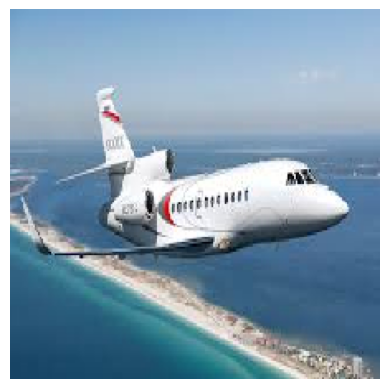

In [16]:
from tensorflow.keras.preprocessing import image
from google.colab import files

# Step 1: Upload image
uploaded = files.upload()

# Get the uploaded file path
for fn in uploaded.keys():
    external_image_path = fn


# Load and preprocess image
img = image.load_img(external_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Predict using CNN Model
predictions = cnn_model.predict(img_array)
top_3_indices = predictions[0].argsort()[-3:][::-1]

# Get class labels
class_labels = dict((v, k) for k, v in train_generator.class_indices.items())

# Show Top-3 predictions
print("Top 3 Predicted Aircraft Types:")
for idx in top_3_indices:
    print(f"{class_labels[idx]} → {predictions[0][idx] * 100:.2f}%")

# Show the image
plt.imshow(img)
plt.axis("off")
plt.show()


**# MobileNetV2 Model **

**Build MobileNetV2 Model**

**Description:**
In this code, I use **MobileNetV2** as a base model for feature extraction while keeping its pre-trained weights unchanged. I then apply **GlobalAveragePooling2D** to reduce the dimensionality of the extracted features, followed by a **Dense** layer with 256 neurons using **ReLU** activation to enhance learning. To prevent overfitting, I include a **Dropout (0.5)** layer. Finally, I add an output layer with **softmax** activation, ensuring the model can classify images into multiple categories. The model is compiled with the **Adam optimizer** and **categorical cross-entropy** as the

In [17]:

# Get number of classes
num_classes = train_generator.num_classes

# Load MobileNetV2 base model (pretrained on ImageNet)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze the base model

# Build the classification model
mobilenet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
mobilenet_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,611,620 (9.96 MB)

 Trainable params: 353,636 (1.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Prepare Callbacks for Training**



**Description:** In this code, I define a **save path** for storing the best-trained MobileNetV2 model. Then, I set up **callbacks** to improve the training process. The `EarlyStopping` callback monitors **validation accuracy** and stops training if there’s no improvement for **5 consecutive epochs**, while restoring the best weights. The `ModelCheckpoint` callback ensures that only the best-performing model, based on validation accuracy, is saved at the specified path.




In [18]:


# Prepare callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint('mobilenetv2_fighter_jet_model.keras', save_best_only=True)  # Save best model
]


**Train the Model**

**Description:** In this code, I train the **MobileNetV2** model using the **fit()** function. The training data is provided via `train_generator`, and the model runs for **15 epochs** to learn patterns from the dataset. Validation data is supplied through `val_generator` to evaluate performance after each epoch. Additionally, I include **callbacks** to stop training early if needed and save the best model based on validation accuracy.




In [ ]:
# Train the MobileNetV2 model
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

print(" MobileNetV2 Training Completed!")


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.0208 - loss: 4.6942 - val_accuracy: 0.0640 - val_loss: 4.2559 - learning_rate: 5.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.0662 - loss: 4.1829 - val_accuracy: 0.1255 - val_loss: 3.8715 - learning_rate: 5.0000e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.1101 - loss: 3.8277 - val_accuracy: 0.1555 - val_loss: 3.6407 - learning_rate: 5.0000e-04
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.1525 - loss: 3.5335 - val_accuracy: 0.1825 - val_loss: 3.4314 - learning_rate: 5.0000e-04
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.1736 - loss: 3.3431 - val_accuracy: 0.1970 - val_loss: 3.3235 - learning_rate: 5.0000e-04
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.2036 - loss: 3.1611 - val_accuracy: 0.2155 - val_loss: 3.2065 - learning_rate: 5.0000e-04
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - acc

**Evaluate MobileNetV2 on Validation Data**

**Description**: In this code, I **evaluate the trained MobileNetV2 model** using `val_generator`. The `evaluate()` function calculates the **validation loss and accuracy**, helping to measure the model’s performance on unseen data. Finally, I **print the results**, displaying the validation accuracy as a percentage and the validation loss rounded to four decimal places.



In [ ]:

# Load the best saved model
mobilenet_model = load_model('mobilenetv2_fighter_jet_model.keras')

# Evaluate on validation set
loss, accuracy = mobilenet_model.evaluate(val_generator)
print(" MobileNetV2 Validation Accuracy: {:.2f}%".format(accuracy * 100))
print(" MobileNetV2 Validation Loss:", loss)


**Save Mode**

**Description:** In this code, I **save the trained MobileNetV2 model** to disk using the `save()` function. The model is stored as `"mobilenetv2_fighter_jet_model_final.keras"`, allowing me to reload it later for inference or further training. Lastly, I **print a success message** to confirm that the model has been saved properly.


In [ ]:
mobilenet_model.save("mobilenetv2_fighter_jet_model_final.keras")
print(" MobileNetV2 Model Saved Manually (Optional).")


**Test Predict External Image + Show Top 3 Probabilities**

**Description:** In this code, I **load the trained MobileNetV2 model** from disk to perform predictions on external images. First, I **upload an image**, retrieve its filename, and preprocess it by resizing, converting it into an array, expanding dimensions, and normalizing pixel values. Then, I **use the model to predict** the class of the image, obtaining an array of probabilities for each category.  

To display results, I **map predictions to class labels**, extract the **top 3 predictions**, and print them with their confidence scores. Finally, I **visualize the uploaded image** using Matplotlib, displaying the top predicted aircraft class as the title.  



In [ ]:


# Path to external image
external_image_path = "/content/aircraft_data/test_image.jpg"  # Change this path

# Load and preprocess external image
img = image.load_img(external_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Predict using the model
predictions = mobilenet_model.predict(img_array)
top_3_indices = predictions[0].argsort()[-3:][::-1]

# Get class labels
class_labels = dict((v, k) for k, v in train_generator.class_indices.items())

# Show Top-3 predictions
print("Top 3 Predicted Aircraft Types:")
for idx in top_3_indices:
    print(f"{class_labels[idx]} → {predictions[0][idx] * 100:.2f}%")

# Show the image
plt.imshow(img)
plt.axis("off")
plt.show()


# **Fine-Tune MobileNetV2**

**Unfreeze Model and Prepare for Fine-Tuning**

**Description:** Now, I am preparing the **MobileNetV2** model for fine-tuning. First, I load the previously trained model to build upon its existing knowledge. I set **trainable=True**, but only for the **deeper layers**, keeping the initial layers frozen to retain essential learned features. Finally, I **recompile** the model using a **lower learning rate**, ensuring that the training process refines the model without erasing its prior learning.



In [ ]:

# Load previously trained MobileNetV2 model
finetune_model = load_model('mobilenetv2_fighter_jet_model.keras')

# Unfreeze base model for fine-tuning
finetune_model.layers[0].trainable = True  # Unfreeze the base MobileNetV2

# Let's freeze first few layers to avoid overfitting and speed up
for layer in finetune_model.layers[0].layers[:100]:   # freeze first 100 layers (optional tweakable number)
    layer.trainable = False

# Compile again with lower learning rate
finetune_model.compile(
    optimizer=Adam(learning_rate=0.00005),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Check trainable layers
finetune_model.summary()


**Train Fine-Tuned Model + Evaluate + Save Best Model**

**Description:**
Now, I will train the model using three key techniques to enhance its performance. **EarlyStopping** will monitor progress and automatically stop training if there is no improvement, preventing unnecessary computation. **ReduceLROnPlateau** will lower the learning rate if the model gets stuck, helping it to continue learning more effectively. Finally, **ModelCheckpoint** will ensure that only the best fine-tuned model is saved, allowing me to use the most optimized version for future predictions.



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Prepare callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint('mobilenetv2_finetuned_model.keras', save_best_only=True)  # Save best version
]

# Train the fine-tuned model
history_finetune = finetune_model.fit(
    train_generator,
    epochs=20,  # Fine-tuning usually needs fewer epochs
    validation_data=val_generator,
    callbacks=callbacks
)

print(" Fine-tuning Completed!")

# Evaluate on validation data
loss, accuracy = finetune_model.evaluate(val_generator)
print(" Fine-Tuned MobileNetV2 Validation Accuracy: {:.2f}%".format(accuracy * 100))
print(" Fine-Tuned MobileNetV2 Validation Loss:", loss)

# Save the fine-tuned model (optional, already saved in checkpoint)
finetune_model.save("mobilenetv2_finetuned_model_final.keras")
print(" Fine-tuned model saved manually.")

**Predict external image + Show Top-3 Predictions**

**Description: **
After completing the training, I evaluate the model using **validation data** to assess its performance. If needed, I **save the model again** to ensure I have the optimized version stored. Finally, I **test an external image**, allowing the model to predict the **top 3 possible categories**, providing insights into its classification accuracy.


In [ ]:

# Path to external image
external_image_path = "/content/aircraft_data/test_image.jpg"

# Load and preprocess
img = image.load_img(external_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Predict
predictions = finetune_model.predict(img_array)
top_3_indices = predictions[0].argsort()[-3:][::-1]

# Get class labels
class_labels = dict((v, k) for k, v in train_generator.class_indices.items())

print("Top 3 Predicted Aircraft Types (Fine-Tuned):")
for idx in top_3_indices:
    print(f"{class_labels[idx]} → {predictions[0][idx] * 100:.2f}%")

# Show image
plt.imshow(img)
plt.axis("off")
plt.show()

# **Final plane image prediction**

**Description:**

After uploading, you can choose which trained model you want to use:
* CNN model
* MobileNetV2 model
* Fine-tuned MobileNetV2 model (recommended for best accuracy).

After you select the model (just by entering 1, 2, or 3), the model will:
Load the image and prepare it for prediction (resize and normalize).
Run prediction using the selected model.
Get the Top 3 possible aircraft types and show their confidence (how sure the model is).
Show the uploaded image and print the Top prediction as a title on the image for easy understanding.



In [ ]:

# Dictionary to map model number to model file
model_paths = {
    "1": "cnn_fighter_jet_model.keras",                  # CNN Model
    "2": "mobilenetv2_fighter_jet_model.keras",          # MobileNetV2 (Standard)
    "3": "mobilenetv2_finetuned_model_final.keras"       # MobileNetV2 (Fine-Tuned)
}

# Select the model
print("Choose the model to use:")
print("1 - CNN Model")
print("2 - MobileNetV2 Model")
print("3 - Fine-Tuned MobileNetV2 Model")
model_choice = input("Enter model number (1 / 2 / 3): ").strip()

# Check if model choice is valid
if model_choice not in model_paths:
    print(" Invalid model choice. Please select 1, 2, or 3.")
else:
    # Load the selected model
    selected_model_path = model_paths[model_choice]
    model = load_model(selected_model_path)
    print(f" Loaded model: {selected_model_path}")

    # Upload image
    from google.colab import files
    uploaded = files.upload()

    # Get uploaded file path
    image_path = next(iter(uploaded))

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize

    # Predict
    predictions = model.predict(img_array)
    top_3_indices = predictions[0].argsort()[-3:][::-1]

    # Get class labels
    class_labels = dict((v, k) for k, v in train_generator.class_indices.items())

    # Display results
    print("\nTop 3 Predicted Aircraft Types:")
    for idx in top_3_indices:
        print(f"{class_labels[idx]} → {predictions[0][idx] * 100:.2f}%")

    # Show the image
    plt.imshow(img)
    plt.axis("off")
    plt.title("Predicted Aircraft Top-3 Results")
    plt.show()


# **Compare Between 3 Models (CNN + MobileNetV2 + Fine-Tuned MobileNetV2)**

**Description:**
In this section, I will **load all saved models**, evaluate them using the same validation dataset, and **collect their accuracy and loss** results. To make the comparison clear, I will **display the results in a table** and **visualize them using a bar chart**. This will help me determine **which model performs best** and **which one should be used for final predictions**.


In [ ]:


# List of model paths and names
models_info = {
    "CNN Model": "cnn_fighter_jet_model.keras",
    "MobileNetV2": "mobilenetv2_fighter_jet_model.keras",
    "Fine-Tuned MobileNetV2": "mobilenetv2_finetuned_model_final.keras"
}

# To store results
results = {}

# Evaluate each model
for model_name, model_path in models_info.items():
    print(f" Evaluating {model_name}...")

    # Load model
    model = load_model(model_path)

    # Evaluate
    loss, accuracy = model.evaluate(val_generator)

    # Store results
    results[model_name] = {
        "Accuracy": accuracy * 100,
        "Loss": loss
    }

# Show results
print("\n Model Comparison Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: Accuracy = {metrics['Accuracy']:.2f}%, Loss = {metrics['Loss']:.4f}")

# Prepare data for plotting
model_names = list(results.keys())
accuracies = [metrics["Accuracy"] for metrics in results.values()]
losses = [metrics["Loss"] for metrics in results.values()]

# Plot accuracy comparison
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color=["blue", "green", "orange"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.show()

# Plot loss comparison
plt.figure(figsize=(10, 5))
plt.bar(model_names, losses, color=["blue", "green", "orange"])
plt.title("Model Loss Comparison")
plt.ylabel("Loss")
plt.show()
